In [804]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="dark")
from scipy import stats
from collections import defaultdict

In [752]:
df = pd.read_csv('all_results.csv', dtype={'indices': str})
df.head()

,Unnamed: 0,name,algo_name,indices,ratingfrac,userfrac,Unnamed: 0.1,fit_time_all,fit_time_all-like-boycott,fit_time_boycott,...,rmse_all-like-boycott,rmse_boycott,rmse_like-boycott,rmse_non-boycott,test_times_all,test_times_all-like-boycott,test_times_boycott,test_times_like-boycott,test_times_non-boycott,type
0,0,Under 18 excluded,KNNBaseline_item_msd,NaN,1.0,0.5,0000_KNNBaseline_item_msd,15.369191,15.369191,15.369191,...,1.037459,1.114452,0.975736,0.884181,72.178317,147.016764,145.116230,146.157918,143.804212,age
1,1,Under 18 excluded,SVD,NaN,1.0,0.5,0000_SVD,50.034708,50.034708,50.034708,...,1.050087,1.146766,0.973409,0.873110,5.351329,13.862198,13.738694,13.788180,12.382417,age
2,2,18-24 excluded,KNNBaseline_item_msd,NaN,1.0,0.5,0001_KNNBaseline_item_msd,14.830245,14.830245,14.830245,...,0.980092,1.024963,0.932439,0.883220,67.848187,145.769697,134.199337,139.798115,132.662584,age
3,3,18-24 excluded,SVD,NaN,1.0,0.5,0001_SVD,46.507224,46.507224,46.507224,...,0.969206,1.024393,0.907940,0.872343,8.074041,18.028050,16.748750,17.024271,14.578683,age
4,4,25-34 excluded,KNNBaseline_item_msd,NaN,1.0,0.5,0002_KNNBaseline_item_msd,12.761534,12.761534,12.761534,...,0.929651,0.979513,0.881714,0.887886,67.996376,169.768699,135.248222,151.481311,132.072707,age


Let's apply transformation that will affect the entire dataframe (e.g. string edits)

In [753]:
id_vars = ['name','algo_name', 'indices', 'ratingfrac', 'userfrac', 'num_ratings', 'num_users']
metrics = ['rmse', 'ndcg10',]
organized_experiments = [
    'gender', 'age', 'state',
    'occupation', 'power', 'genre'
]
algo_names = ['KNNBaseline_item_msd', 'SVD']

In [754]:
# flag
samples_df = df[df.name.str.contains('sample')]
samples_df.head()

org_df = df[df['type'].isin(organized_experiments)]

In [755]:
org_df.name = [
    x.replace('excluded', '')
    .replace('users from', '')
    .replace('US_', '')
    .replace('state', '')
    .strip()
    for x in list(org_df.name)
]

C:\Users\Nick\Anaconda3\lib\site-packages\pandas\core\generic.py:2999: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


First, let's see how well the # of ratings correlates with error
This will be an important piece of context for analyzing the experiments.

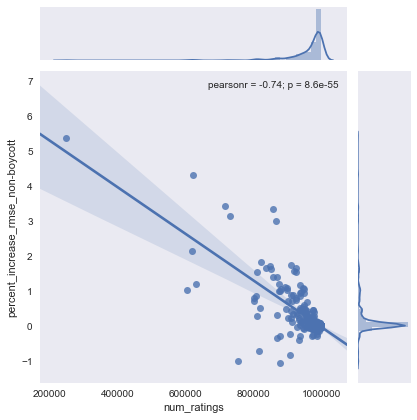

-6.65431676214e-06 6.61417357035 -0.742283000273 8.55492021854e-55
defaultdict(<class 'dict'>, {'KNNBaseline_item_msd': {'rmse': 10.228099520398876}})


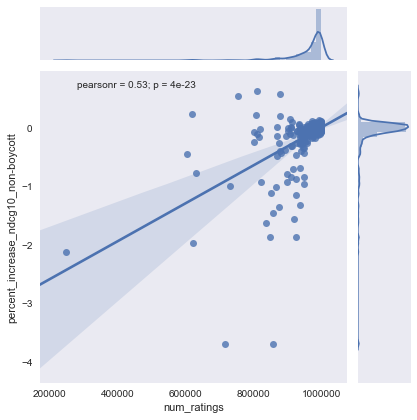

3.24304736207e-06 -3.23524967145 0.525450918893 4.04793828729e-23
defaultdict(<class 'dict'>, {'KNNBaseline_item_msd': {'rmse': 10.228099520398876, 'ndcg10': -2.2345204385429156}})


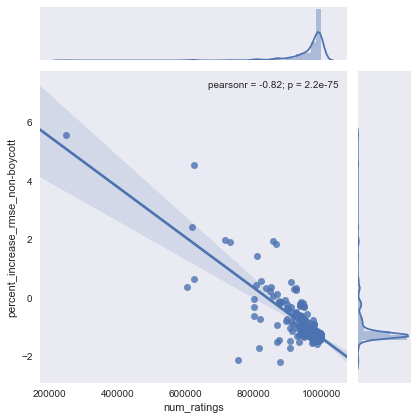

-8.58945054282e-06 7.22343823836 -0.819204470615 2.19068358134e-75
defaultdict(<class 'dict'>, {'KNNBaseline_item_msd': {'rmse': 10.228099520398876, 'ndcg10': -2.2345204385429156}, 'SVD': {'rmse': 10.265763427817257}})


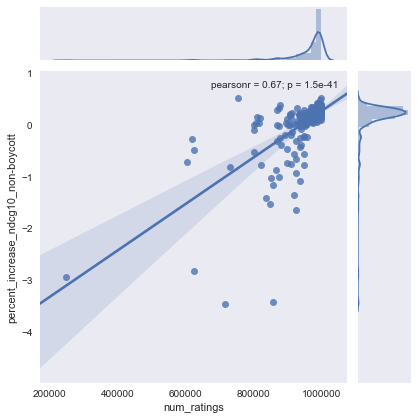

4.49113425121e-06 -4.2224485996 0.671914532406 1.54769894835e-41
defaultdict(<class 'dict'>, {'KNNBaseline_item_msd': {'rmse': 10.228099520398876, 'ndcg10': -2.2345204385429156}, 'SVD': {'rmse': 10.265763427817257, 'ndcg10': -2.5004501095206026}})


In [809]:
algo_to_metric_to_slope = defaultdict(dict)
algo_to_metric_to_intercept = defaultdict(dict)
algo_to_metric_to_average_boycott = defaultdict(dict)
for algo_name in algo_names:
    filt = org_df[org_df.algo_name == algo_name]
    for metric in metrics:
        key = 'percent_increase_{}_non-boycott'.format(metric)
        sns.jointplot(filt.num_ratings, y=filt[key], kind="reg")
        plt.show()
        slope, intercept, r_value, p_value, std_err = stats.linregress(filt.num_ratings, y=filt[key])
        print(slope, intercept, r_value, p_value)
        algo_to_metric_to_slope[algo_name][metric] = slope
        algo_to_metric_to_intercept[algo_name][metric] = intercept
        algo_to_metric_to_average_boycott[algo_name][metric] = np.mean(
            df[df.algo_name == algo_name][key.replace('non-boycott', 'boycott')]
        )
#         algo_to_metric_to_average_boycott[algo_name][metric] = np.mean(
#             filt[key.replace('non-boycott', 'boycott')]
#         )
        
        new_key = key.replace('non-boycott', 'expected')
        kwargs = {new_key: [
            x * slope + intercept for x in list(org_df.num_ratings)
        ]}
        org_df = org_df.assign(**kwargs)

        print(algo_to_metric_to_average_boycott)

In [746]:
# list(samples_df.columns.values)

In [747]:
def select_cols(cols, metrics, groups, percents):
    """ rename?"""
    increase_cols = [
        x for x in cols if (any(metric in x for metric in metrics) and 'increase' in x)
    ]
    increase_cols = [
        x for x in increase_cols if any(group == x.split('_')[-1] for group in groups)
    ]
    if percents:
        increase_cols = [x for x in increase_cols if 'percent' in x]
    else:
        increase_cols = [x for x in increase_cols if 'percent' not in x]
    print(increase_cols)
    return increase_cols

In [776]:
def fill_in_longform(df):
    """Fill in a longform dataframe with metric, group, and name information"""
    df = df.assign(
        metric=[x.split('_')[-2] for x in df.increase_type]
    )
    df = df.assign(
        group=[x.split('_')[-1] for x in df.increase_type]
    )
    return df
    

In [777]:
# grouped factor plot
def plot1(df, metrics, groups, percents=False):
    increase_cols = select_cols(list(df.columns.values), metrics, groups, percents)
    longform = df[increase_cols + id_vars].melt(
        id_vars = id_vars,
        var_name='increase_type'
    )
    longform = fill_in_longform(longform)
    print(longform.head())
    names = list(set(longform.name))
    names = sorted(names, key = lambda x: int(''.join([s for s in x.split() if s.isdigit()])))
    # print(names)
    g = sns.factorplot(
        x="name", y="value", hue="group", data=longform,
        size=6, kind="point", col='algo_name', row='metric',
        # xticks=[1,2,3,4,5,6,7,8],
        order=names
    )
    if percents:
        g.set_ylabels("percent increase")
    else:
        g.set_ylabels("increase")
    g.set_xticklabels(["0.01%", "0.05%", "0.1%", "0.5%", "1%", "5%", "10%", "50%",])
    g.set_xlabels('Percent of Users')
    return g


['percent_increase_ndcg10_all', 'percent_increase_ndcg10_non-boycott', 'percent_increase_rmse_all', 'percent_increase_rmse_non-boycott']
            name             algo_name     indices  ratingfrac  userfrac  \
0  1 user sample  KNNBaseline_item_msd  251-to-500         1.0       1.0   
1  1 user sample                   SVD  251-to-500         1.0       1.0   
2  1 user sample  KNNBaseline_item_msd  251-to-500         1.0       1.0   
3  1 user sample                   SVD  251-to-500         1.0       1.0   
4  1 user sample  KNNBaseline_item_msd  251-to-500         1.0       1.0   

   num_ratings  num_users                increase_type     value  metric group  
0      1000176       6039  percent_increase_ndcg10_all  0.048378  ndcg10   all  
1      1000176       6039  percent_increase_ndcg10_all  0.229382  ndcg10   all  
2      1000118       6039  percent_increase_ndcg10_all  0.004556  ndcg10   all  
3      1000118       6039  percent_increase_ndcg10_all  0.281903  ndcg10   all  
4

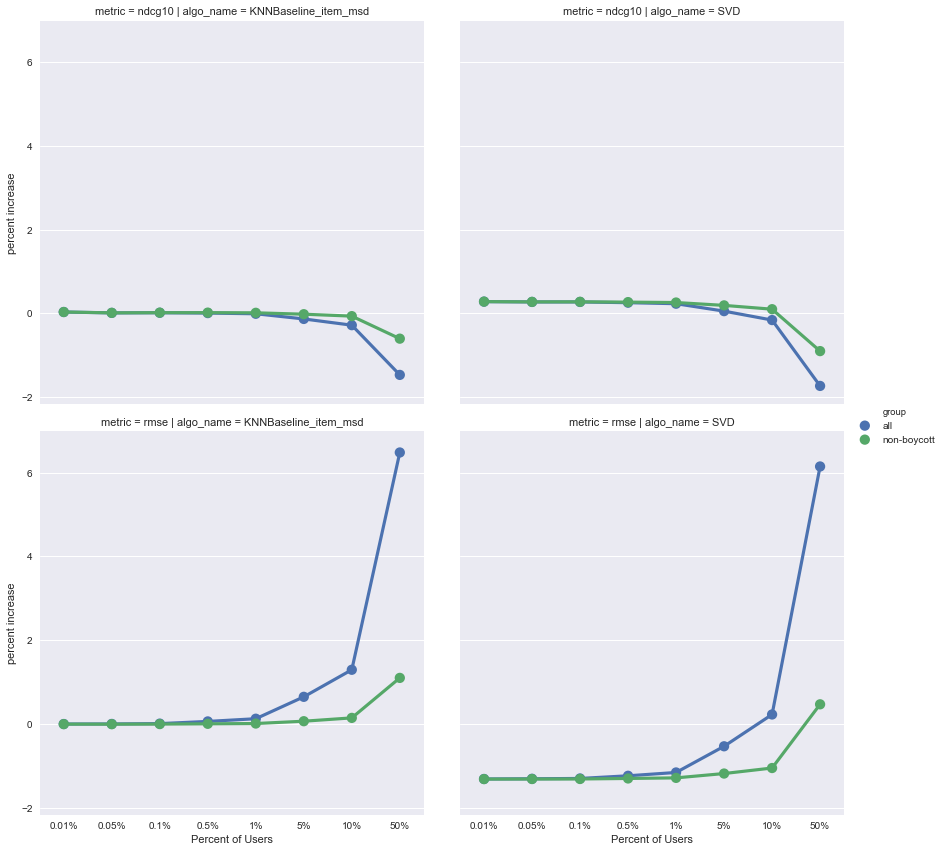

In [778]:
g = plot1(
    samples_df,
    metrics=metrics,
    percents=True,
    groups=['non-boycott', 'all',]
)
plt.show()

['increase_ndcg10_all', 'increase_ndcg10_non-boycott', 'increase_ndcg5_all', 'increase_ndcg5_non-boycott', 'increase_ndcgfull_all', 'increase_ndcgfull_non-boycott', 'increase_prec10t4_all', 'increase_prec10t4_non-boycott', 'increase_prec5t4_all', 'increase_prec5t4_non-boycott', 'increase_rmse_all', 'increase_rmse_non-boycott']
            name             algo_name     indices  ratingfrac  userfrac  \
0  1 user sample  KNNBaseline_item_msd  251-to-500         1.0       1.0   
1  1 user sample                   SVD  251-to-500         1.0       1.0   
2  1 user sample  KNNBaseline_item_msd  251-to-500         1.0       1.0   
3  1 user sample                   SVD  251-to-500         1.0       1.0   
4  1 user sample  KNNBaseline_item_msd  251-to-500         1.0       1.0   

   num_ratings  num_users        increase_type     value  metric group  
0      1000176       6039  increase_ndcg10_all  0.000383  ndcg10   all  
1      1000176       6039  increase_ndcg10_all  0.001815  ndcg10   a

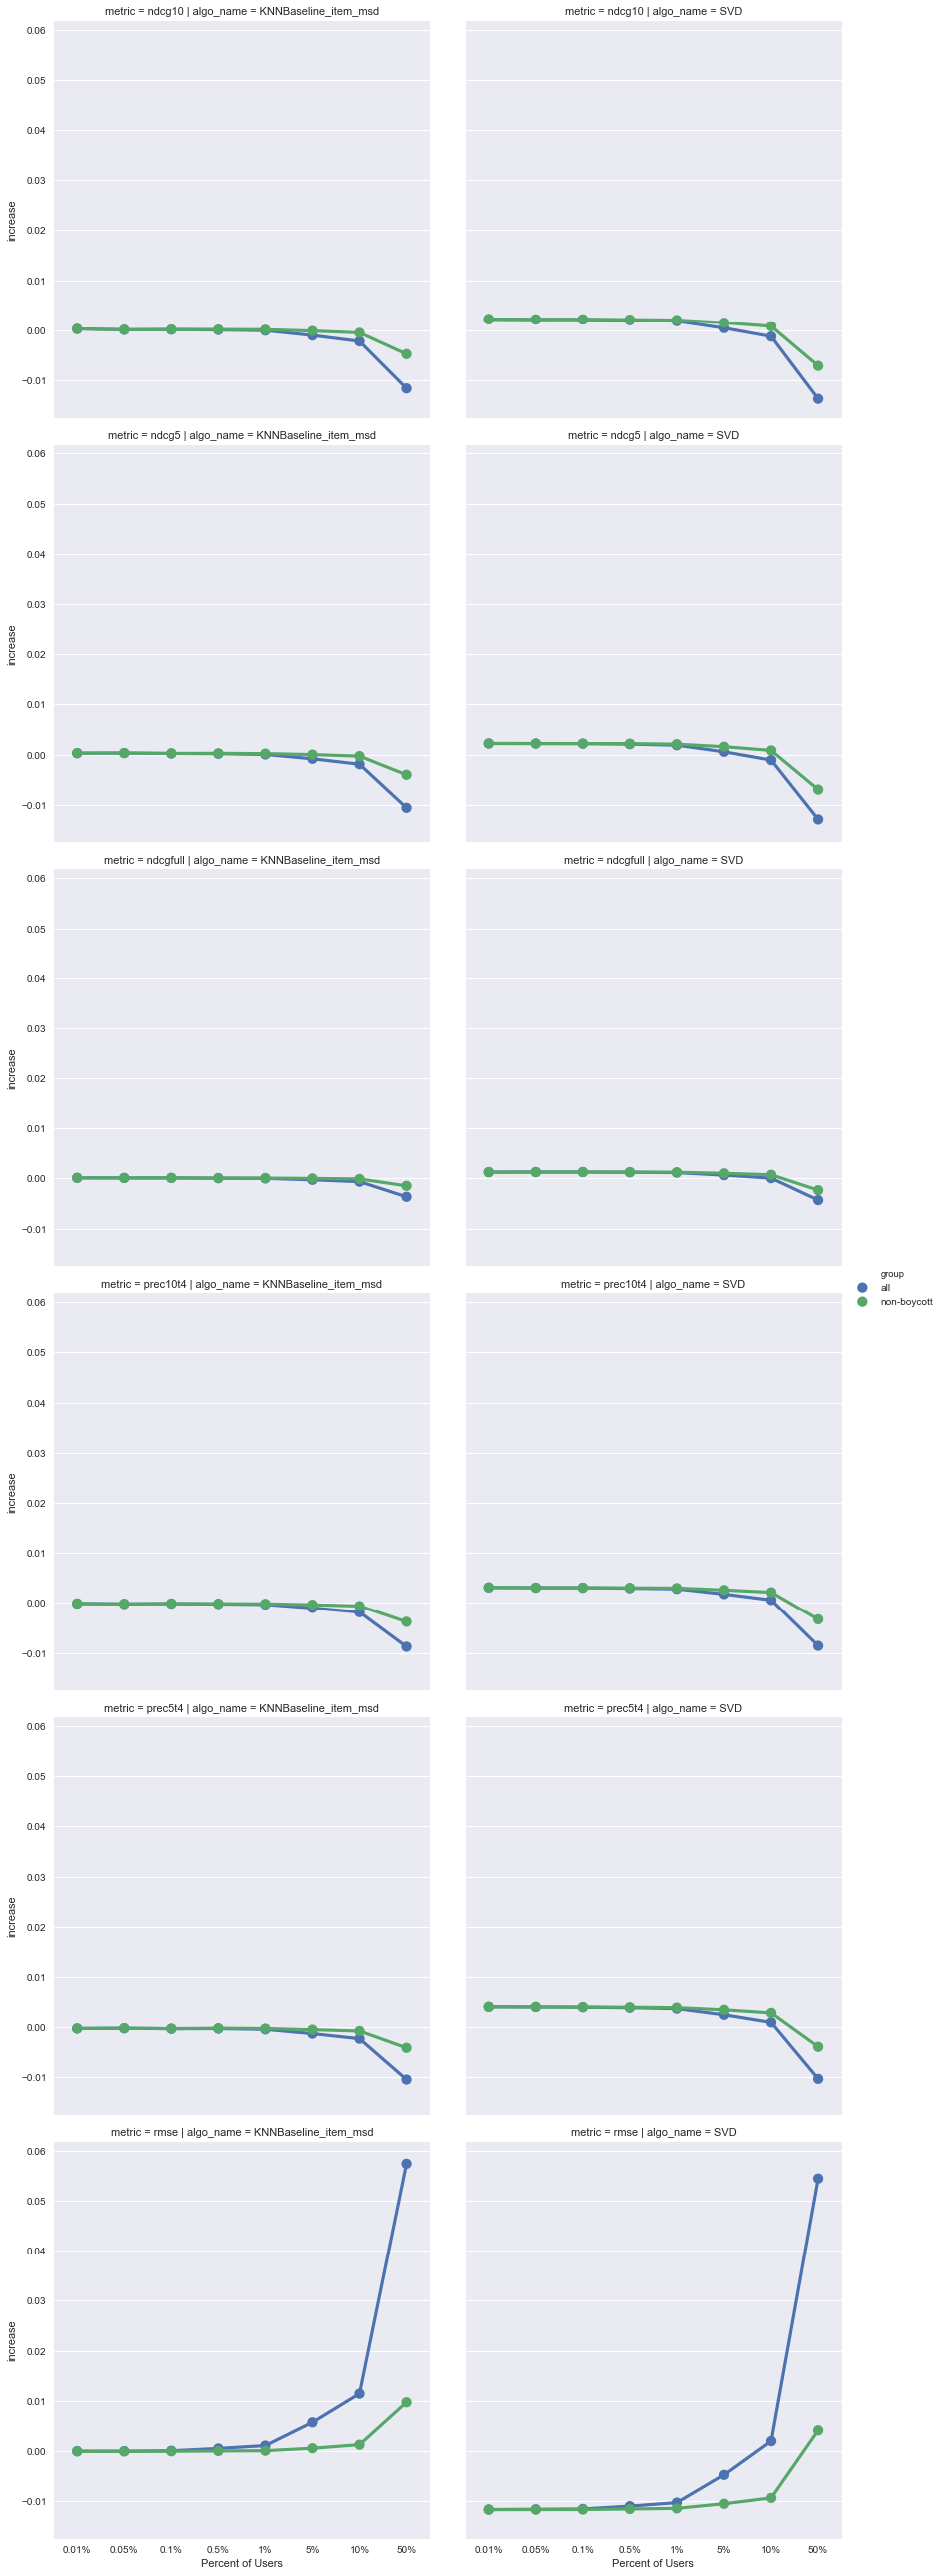

In [787]:
g = plot1(
    samples_df,
    metrics=['rmse', 'ndcg', 'prec'],
    percents=False,
    groups=['non-boycott', 'all',]
)
plt.show()

In [805]:
def plot2(df, metrics, groups, percents=False, kind='bar', size=10):
    increase_cols = select_cols(list(df.columns.values), metrics, groups, percents)
    longform = df[increase_cols + id_vars].melt(
        id_vars = id_vars,
        var_name='increase_type'
    )
    longform = fill_in_longform(longform)
    longform = longform.assign(
        name=['{} ({}k)'.format(
            name, int(round(num_ratings/1000,0))
        ) for name, num_ratings in zip(longform.name, longform.num_ratings)
    ])
    g = sns.factorplot(
        x="value", y="name", hue="group", data=longform,
        size=size, kind=kind, col='algo_name', row='metric',
        sharex=False,
        # linestyles='None',
        # capsize=0.1
    )
    a = g.axes
    
    # flag: hardcoded right now. Not good.
    # use .facet_data() ?
    algo_order = ['KNNBaseline_item_msd', 'SVD']
    metric_order = ['ndcg10', 'rmse']
    for y in range(a.shape[0]):
        for x in range(a.shape[1]):
            val = algo_to_metric_to_average_boycott[algo_order[x]][metric_order[y]]
            g.axes[y,x].axvline(0, color='black', linestyle='-')
            g.axes[y,x].axvline(val, color='black', linestyle='-', linewidth=0.5)


In [790]:
state_boycotts = org_df[org_df['type'] == 'state']
gender_boycotts = org_df[org_df['type'] == 'gender']
age_boycotts = org_df[org_df['type'] == 'age']
occupation_boycotts = org_df[org_df['type'] == 'occupation']
power_boycotts = org_df[org_df['type'] == 'power']
genre_boycotts = org_df[org_df['type'] == 'genre']

In [763]:
def all_users_all_ratings(df):
    return df[(
        (df.userfrac == 1.0) & (df.ratingfrac == 1.0)
    )]

In [764]:
def half_users(df):
    return df[(
        (df.userfrac == 0.5) & (df.ratingfrac == 1.0)
    )]

In [765]:
def half_ratings(df):
    return df[(
        (df.userfrac == 1.0) & (df.ratingfrac == 0.5)
    )]

In [811]:
def plot_all_three_scenarios(df, size=6):
    plot2(
        all_users_all_ratings(df),
        metrics=metrics,
        percents=True,
        groups=['non-boycott', 'boycott', 'expected'],
        size=size
    )
    plot2(
        half_users(df),
        metrics=metrics,
        percents=True,
        groups=['non-boycott', 'like-boycott', 'boycott', 'expected'],
        size=size
    )
    plot2(
        half_ratings(df),
        metrics=metrics,
        percents=True,
        groups=['non-boycott', 'boycott', 'expected'],
        size=size,
    )
    plt.show()

## Let's do gender first...

['percent_increase_ndcg10_boycott', 'percent_increase_ndcg10_non-boycott', 'percent_increase_rmse_boycott', 'percent_increase_rmse_non-boycott', 'percent_increase_rmse_expected', 'percent_increase_ndcg10_expected']
['percent_increase_ndcg10_boycott', 'percent_increase_ndcg10_like-boycott', 'percent_increase_ndcg10_non-boycott', 'percent_increase_rmse_boycott', 'percent_increase_rmse_like-boycott', 'percent_increase_rmse_non-boycott', 'percent_increase_rmse_expected', 'percent_increase_ndcg10_expected']
['percent_increase_ndcg10_boycott', 'percent_increase_ndcg10_non-boycott', 'percent_increase_rmse_boycott', 'percent_increase_rmse_non-boycott', 'percent_increase_rmse_expected', 'percent_increase_ndcg10_expected']


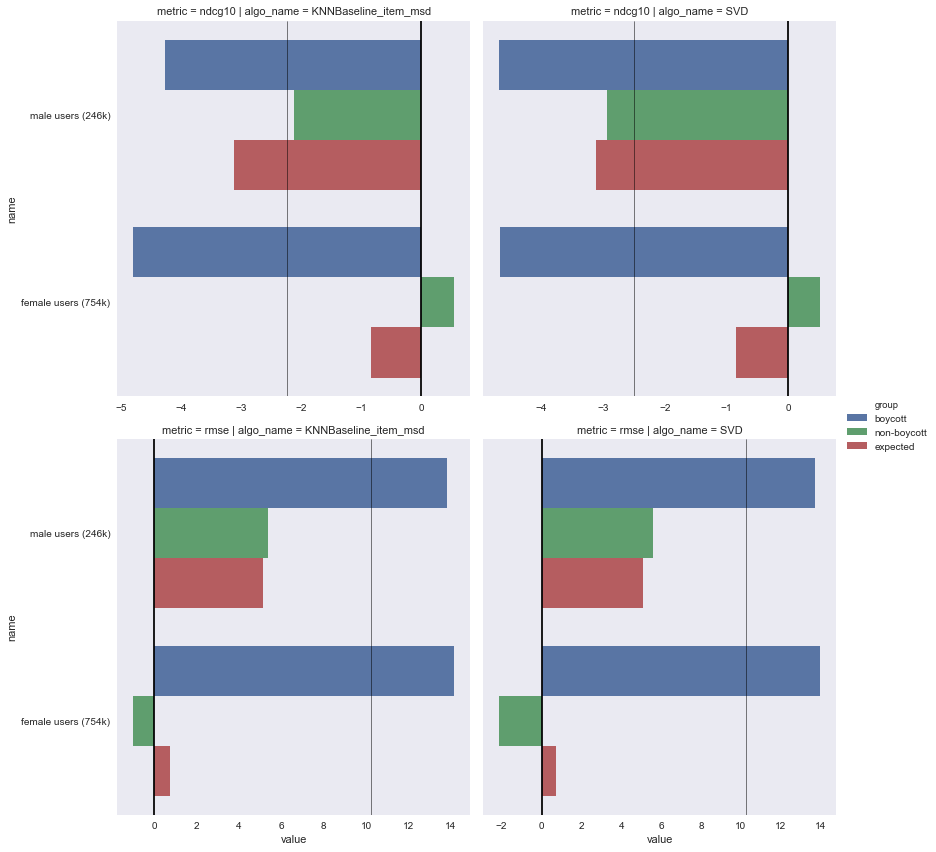

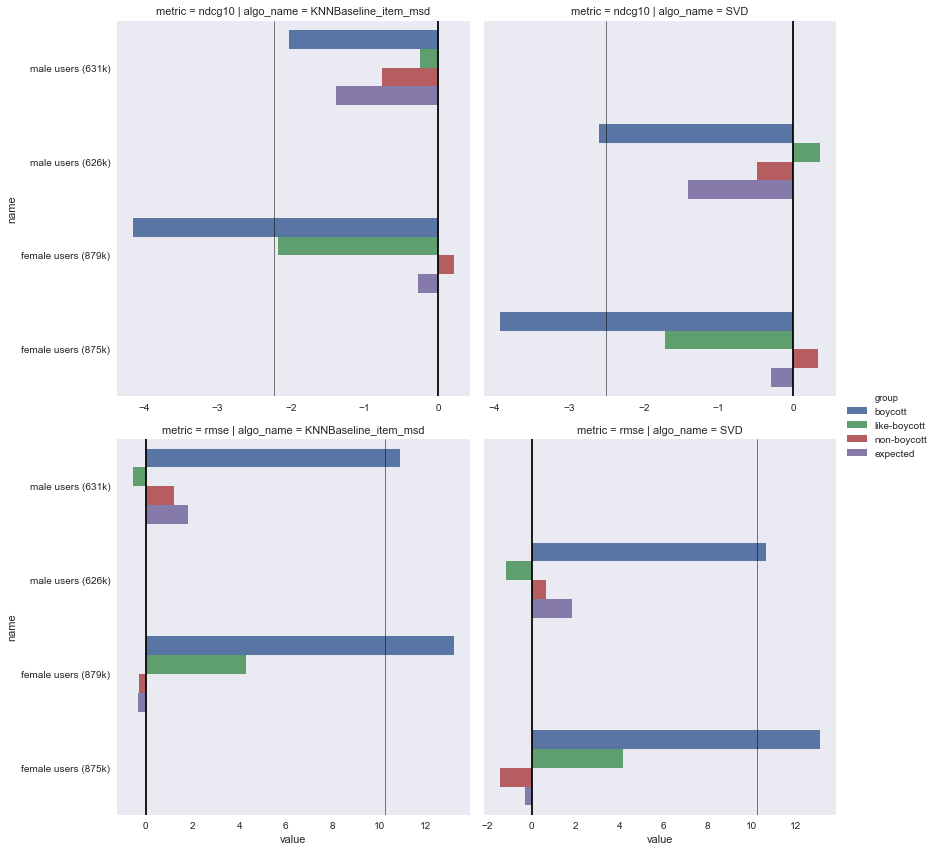

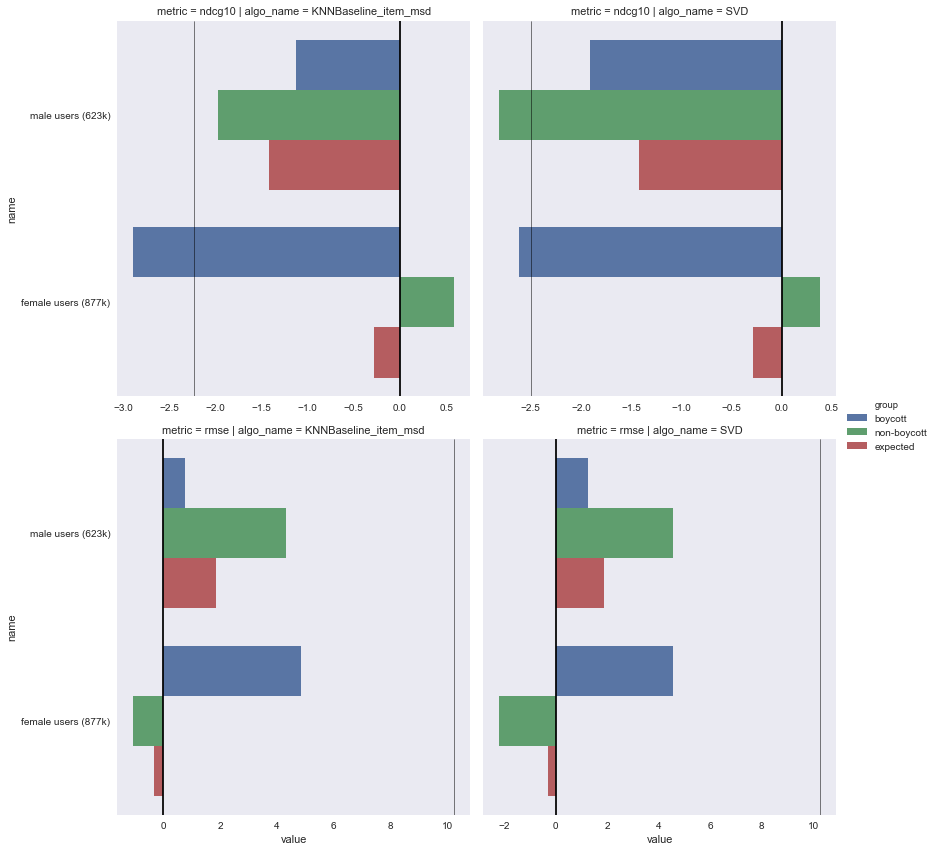

In [812]:
plot_all_three_scenarios(gender_boycotts)

['percent_increase_ndcg10_boycott', 'percent_increase_ndcg10_non-boycott', 'percent_increase_rmse_boycott', 'percent_increase_rmse_non-boycott', 'percent_increase_rmse_expected', 'percent_increase_ndcg10_expected']
['percent_increase_ndcg10_boycott', 'percent_increase_ndcg10_like-boycott', 'percent_increase_ndcg10_non-boycott', 'percent_increase_rmse_boycott', 'percent_increase_rmse_like-boycott', 'percent_increase_rmse_non-boycott', 'percent_increase_rmse_expected', 'percent_increase_ndcg10_expected']
['percent_increase_ndcg10_boycott', 'percent_increase_ndcg10_non-boycott', 'percent_increase_rmse_boycott', 'percent_increase_rmse_non-boycott', 'percent_increase_rmse_expected', 'percent_increase_ndcg10_expected']


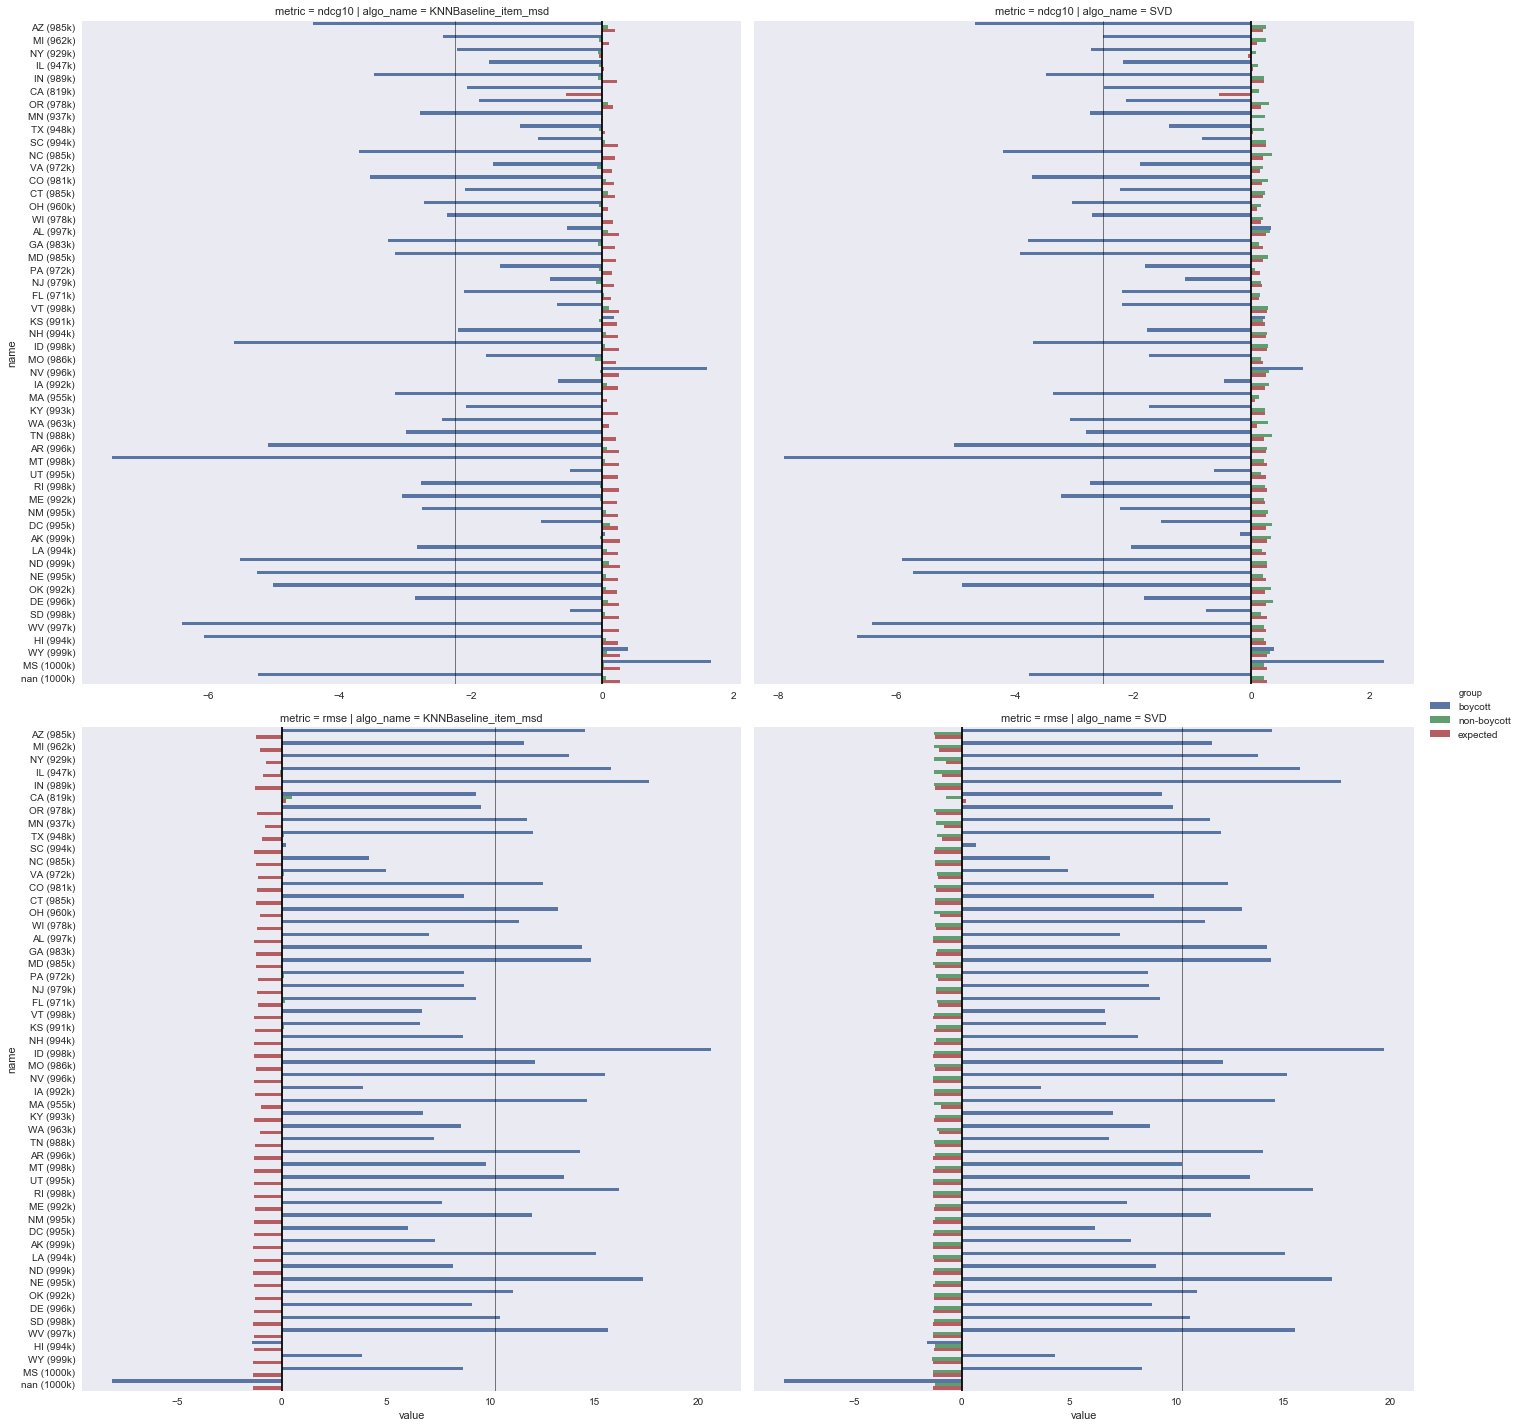

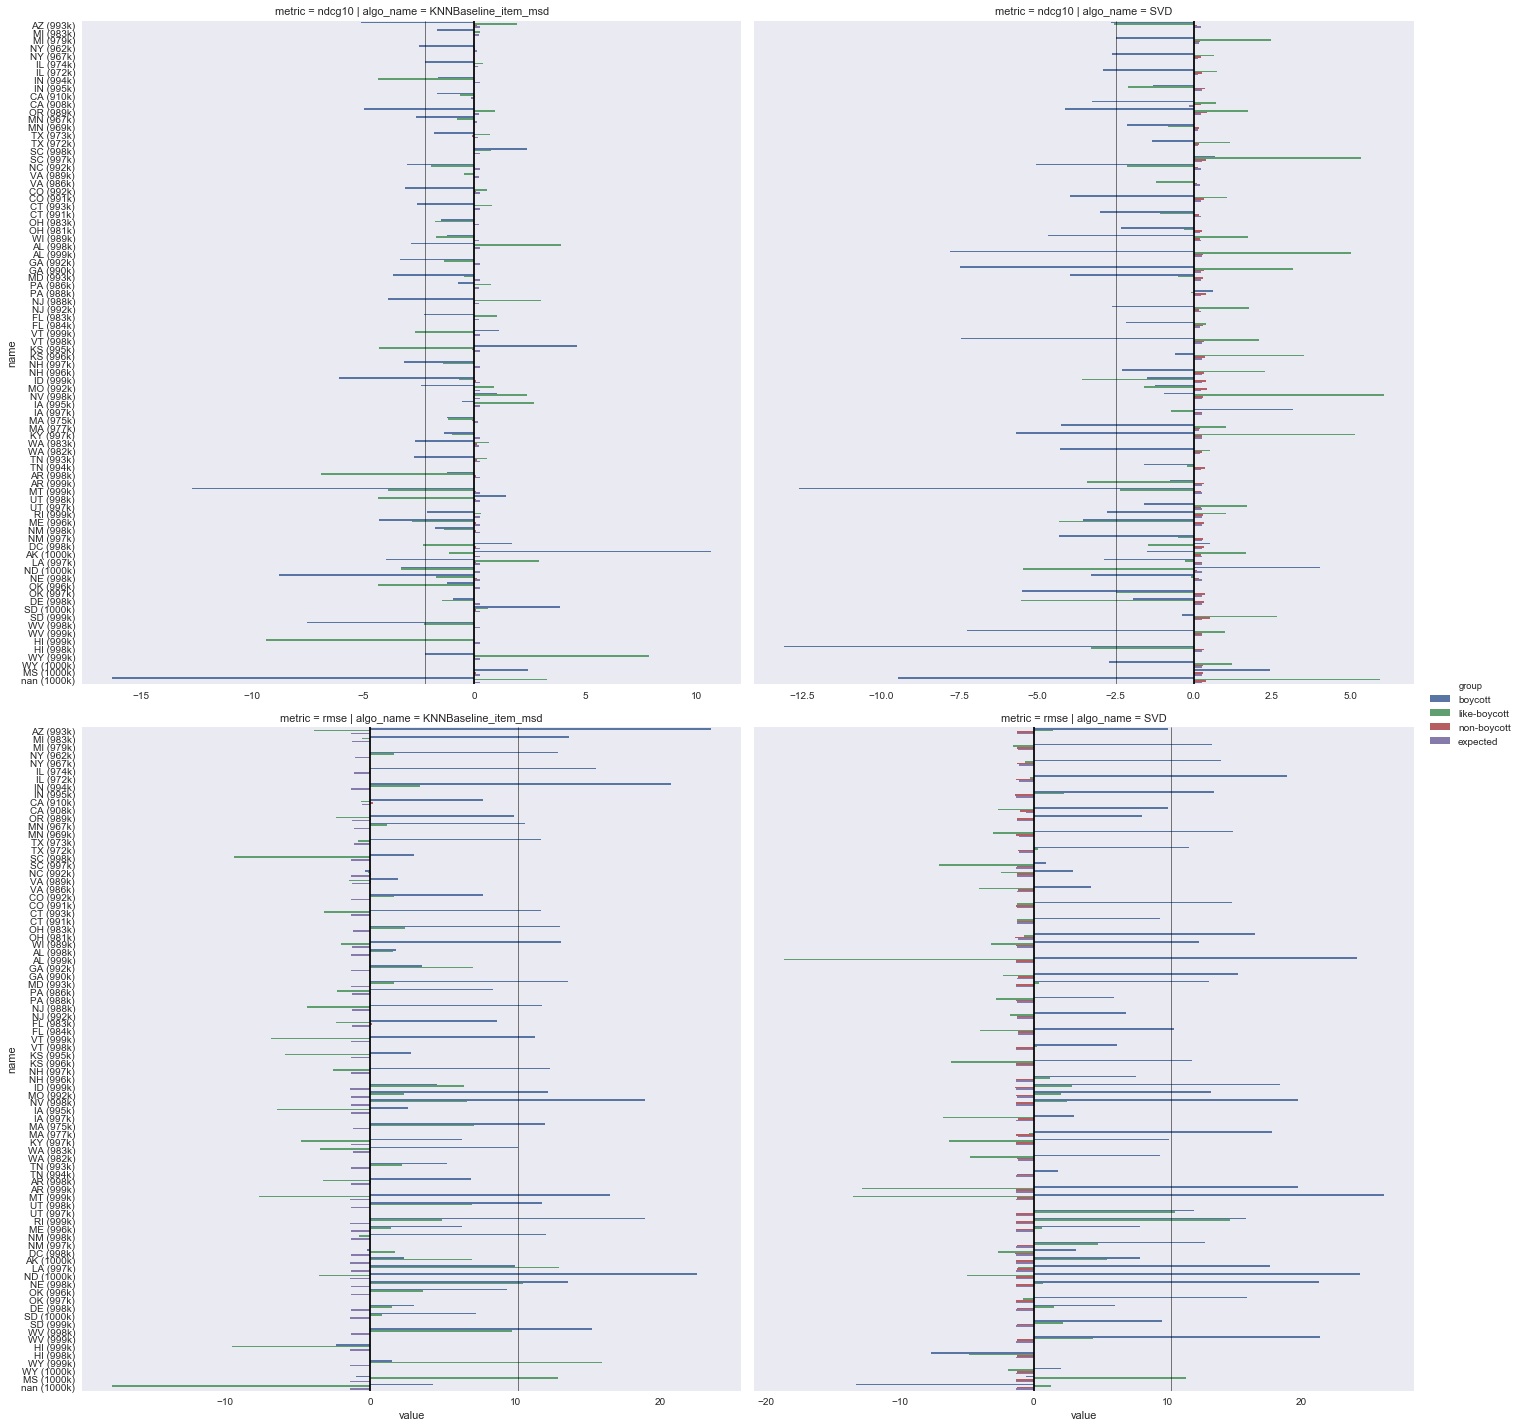

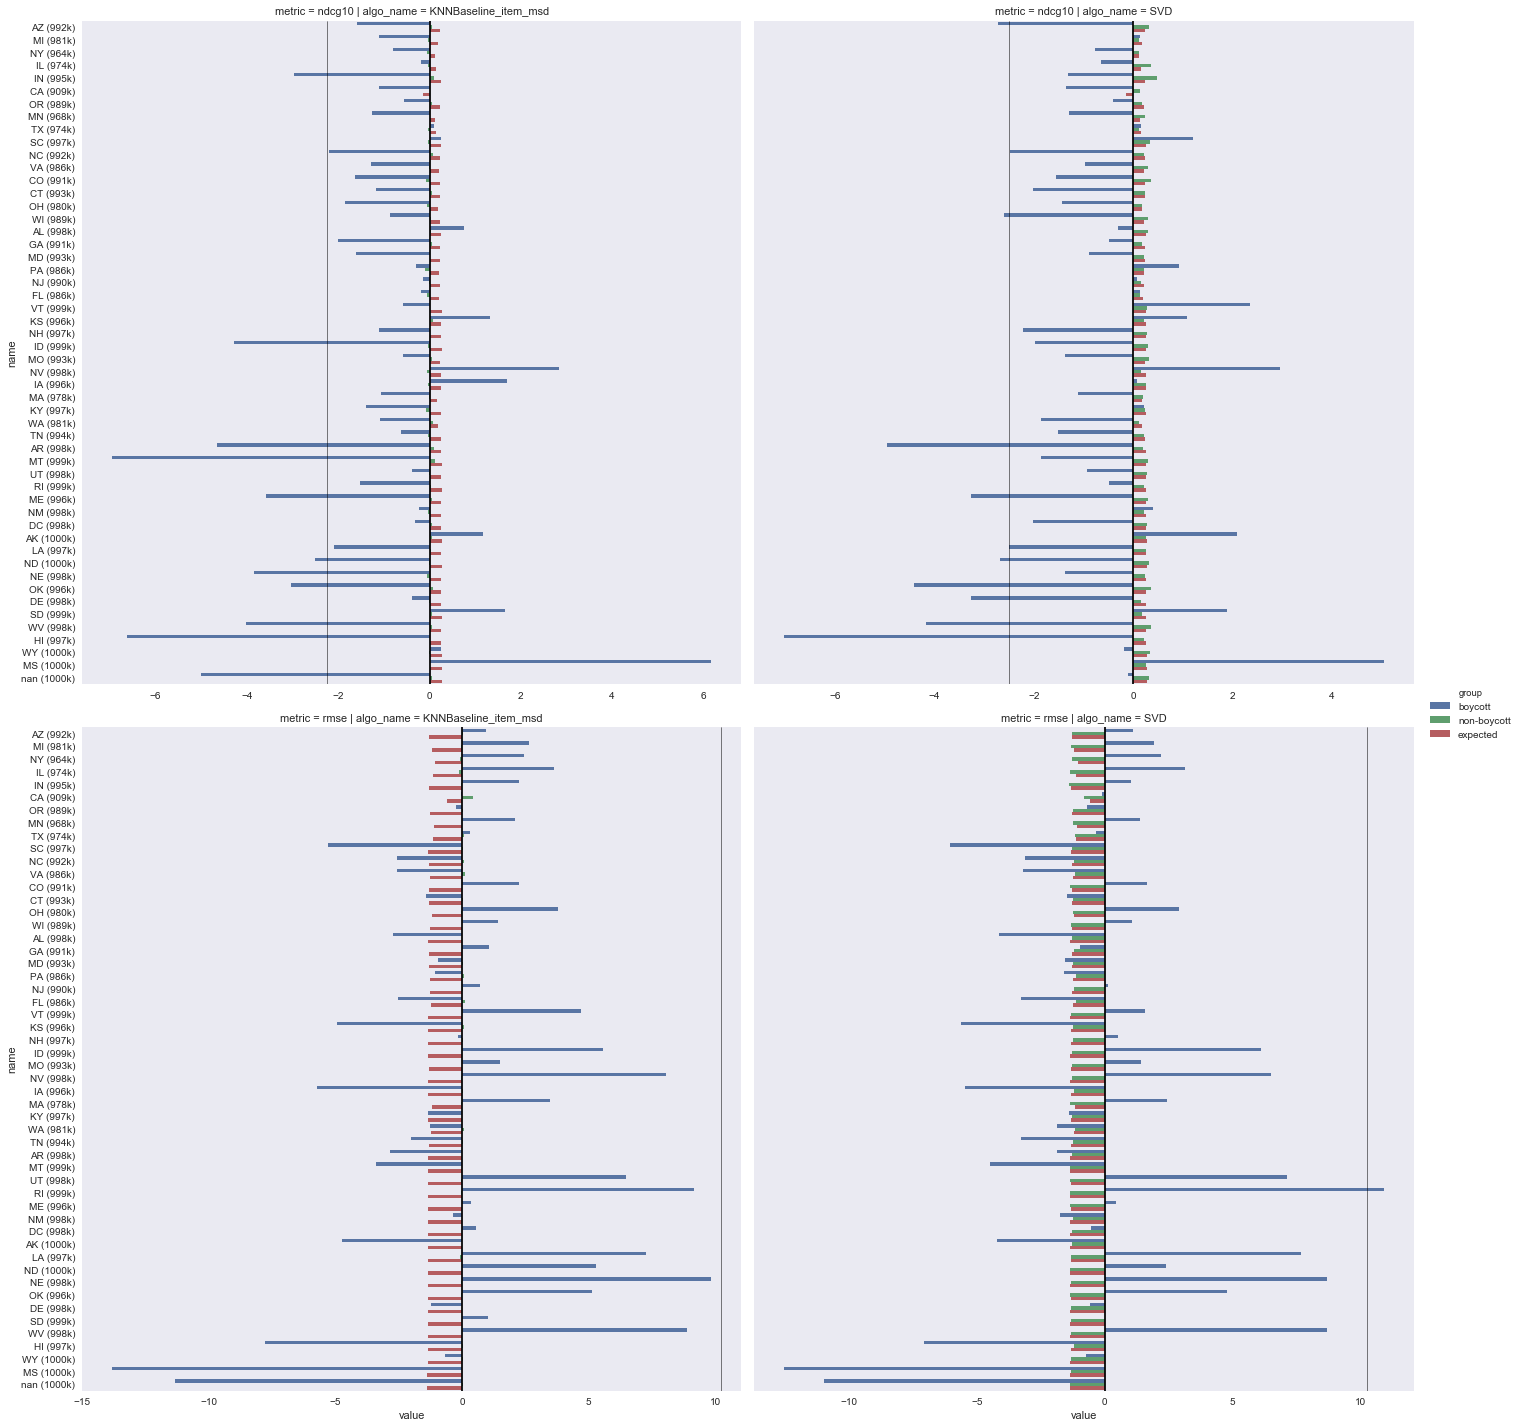

In [807]:
plot_all_three_scenarios(state_boycotts, size=10)

['percent_increase_ndcg10_boycott', 'percent_increase_ndcg10_non-boycott', 'percent_increase_rmse_boycott', 'percent_increase_rmse_non-boycott']
0        Top 10% contributors (618.8k)
1        Top 10% contributors (618.8k)
2     Bottom 10% contributors (985.8k)
3     Bottom 10% contributors (985.8k)
4        Top 10% contributors (618.8k)
5        Top 10% contributors (618.8k)
6     Bottom 10% contributors (985.8k)
7     Bottom 10% contributors (985.8k)
8        Top 10% contributors (618.8k)
9        Top 10% contributors (618.8k)
10    Bottom 10% contributors (985.8k)
11    Bottom 10% contributors (985.8k)
12       Top 10% contributors (618.8k)
13       Top 10% contributors (618.8k)
14    Bottom 10% contributors (985.8k)
15    Bottom 10% contributors (985.8k)
Name: name, dtype: object
['percent_increase_ndcg10_boycott', 'percent_increase_ndcg10_like-boycott', 'percent_increase_ndcg10_non-boycott', 'percent_increase_rmse_boycott', 'percent_increase_rmse_like-boycott', 'percent_increase_r

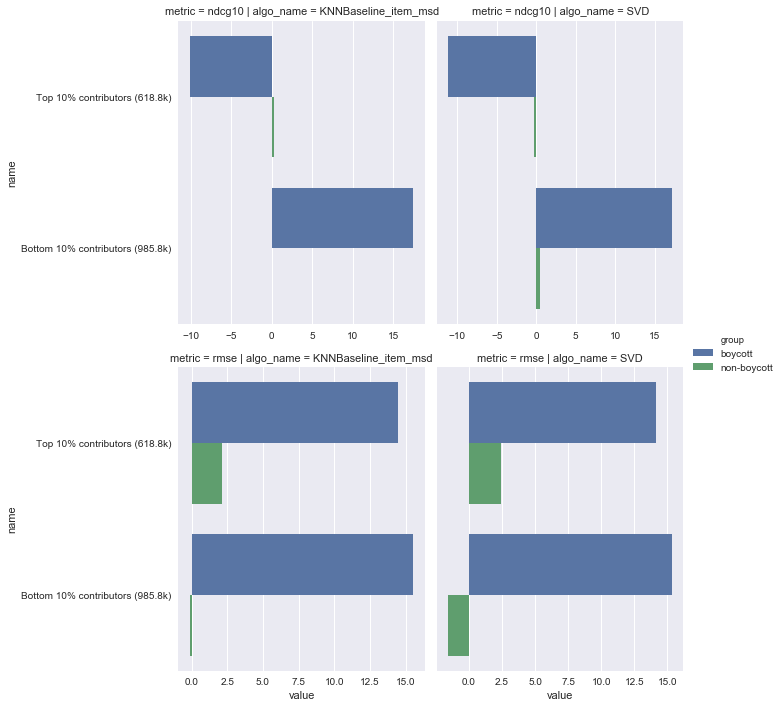

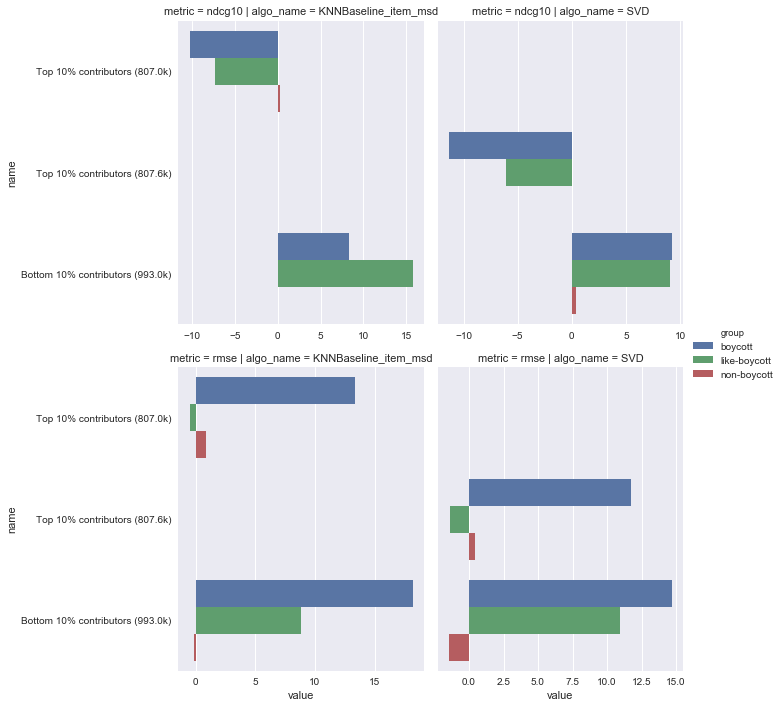

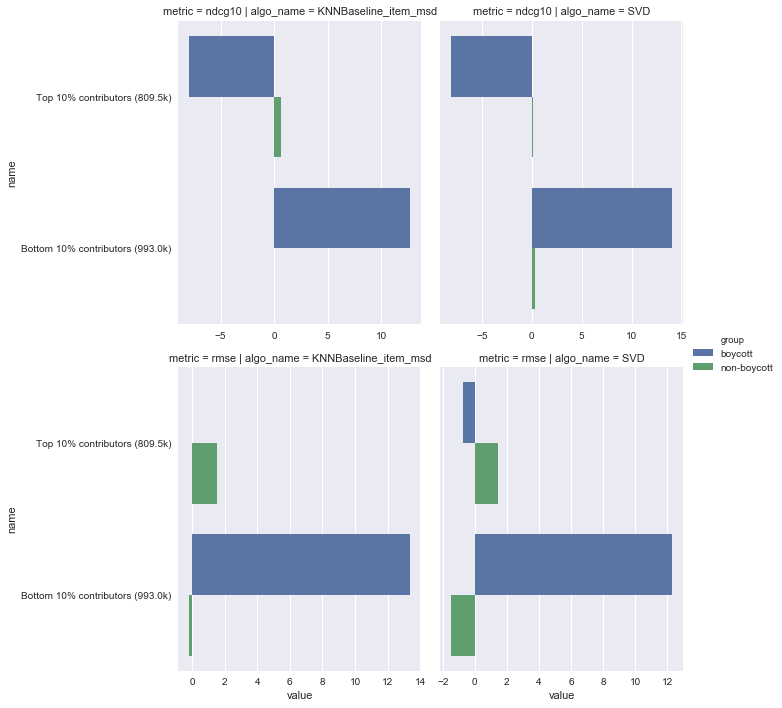

In [769]:
plot_all_three_scenarios(power_boycotts, size=5)

['percent_increase_ndcg10_boycott', 'percent_increase_ndcg10_non-boycott', 'percent_increase_rmse_boycott', 'percent_increase_rmse_non-boycott']
0     Under 18 (973.0k)
1     Under 18 (973.0k)
2        18-24 (816.7k)
3        18-24 (816.7k)
4        25-34 (604.7k)
5        25-34 (604.7k)
6        35-44 (801.2k)
7        35-44 (801.2k)
8        45-49 (916.6k)
9        45-49 (916.6k)
10       50-55 (927.7k)
11       50-55 (927.7k)
12         56+ (961.4k)
13         56+ (961.4k)
14    Under 18 (973.0k)
15    Under 18 (973.0k)
16       18-24 (816.7k)
17       18-24 (816.7k)
18       25-34 (604.7k)
19       25-34 (604.7k)
20       35-44 (801.2k)
21       35-44 (801.2k)
22       45-49 (916.6k)
23       45-49 (916.6k)
24       50-55 (927.7k)
25       50-55 (927.7k)
26         56+ (961.4k)
27         56+ (961.4k)
28    Under 18 (973.0k)
29    Under 18 (973.0k)
30       18-24 (816.7k)
31       18-24 (816.7k)
32       25-34 (604.7k)
33       25-34 (604.7k)
34       35-44 (801.2k)
35       35-44 

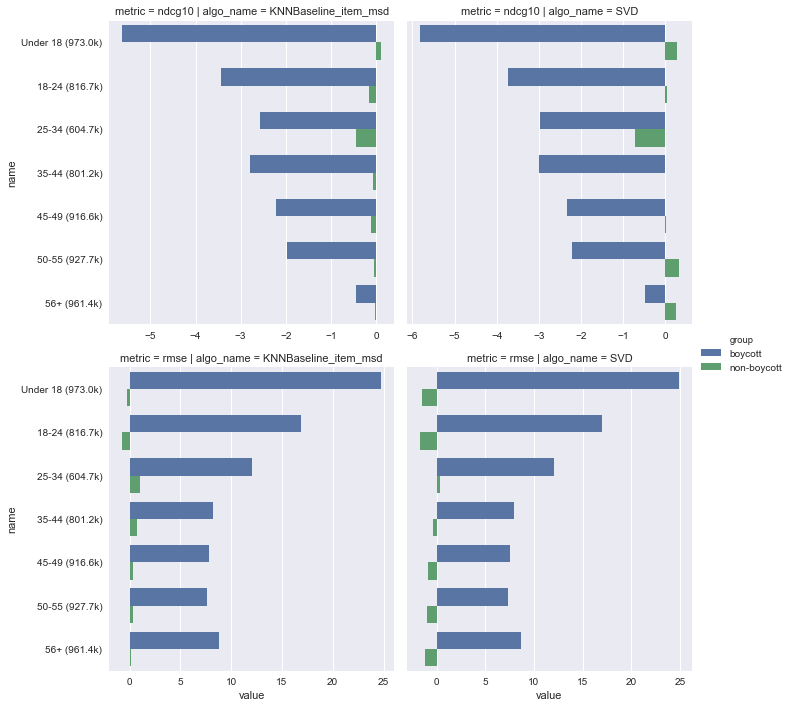

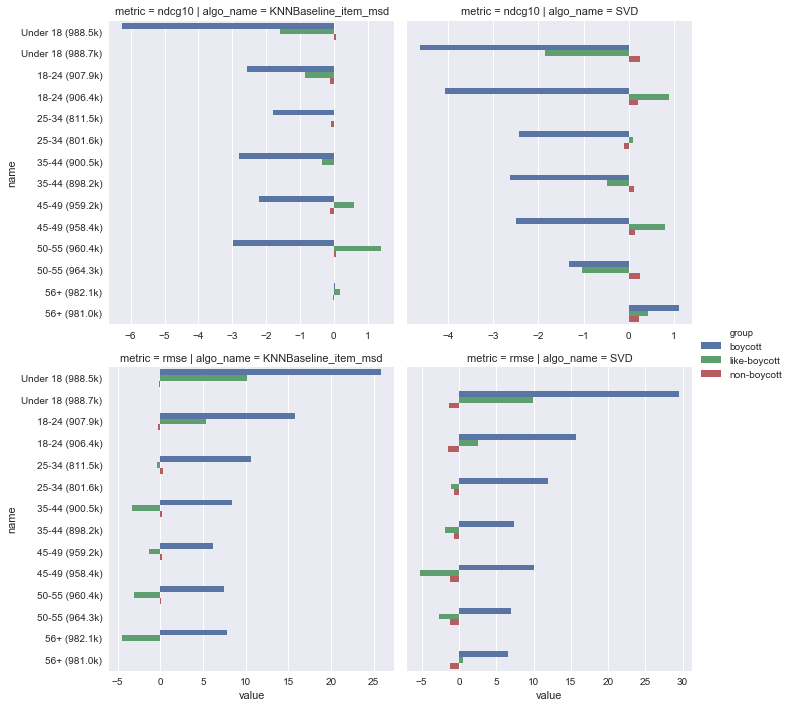

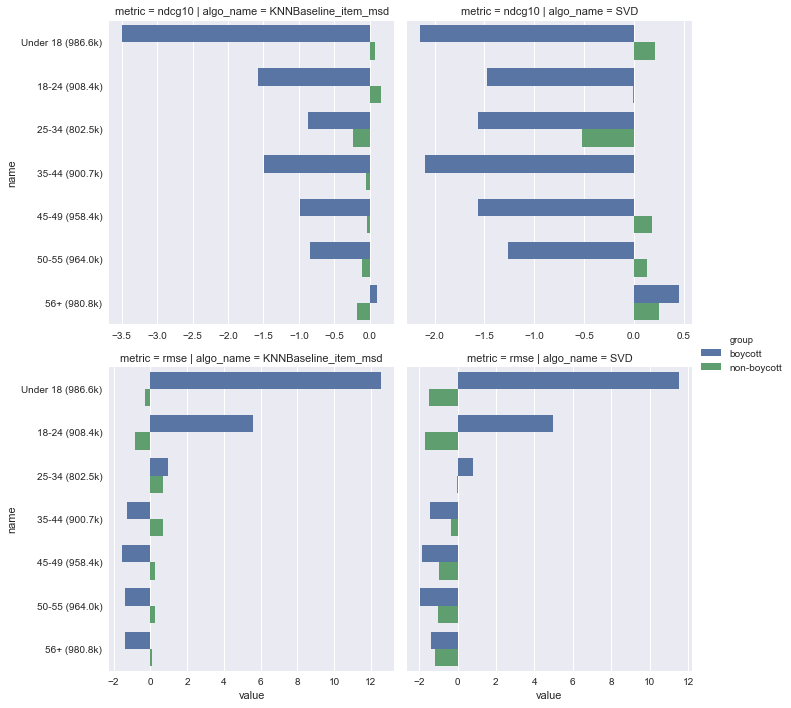

In [770]:
plot_all_three_scenarios(age_boycotts, size=5)

['percent_increase_ndcg10_boycott', 'percent_increase_ndcg10_non-boycott', 'percent_increase_rmse_boycott', 'percent_increase_rmse_non-boycott', 'percent_increase_rmse_expected', 'percent_increase_ndcg10_expected']
['percent_increase_ndcg10_boycott', 'percent_increase_ndcg10_like-boycott', 'percent_increase_ndcg10_non-boycott', 'percent_increase_rmse_boycott', 'percent_increase_rmse_like-boycott', 'percent_increase_rmse_non-boycott', 'percent_increase_rmse_expected', 'percent_increase_ndcg10_expected']
['percent_increase_ndcg10_boycott', 'percent_increase_ndcg10_non-boycott', 'percent_increase_rmse_boycott', 'percent_increase_rmse_non-boycott', 'percent_increase_rmse_expected', 'percent_increase_ndcg10_expected']


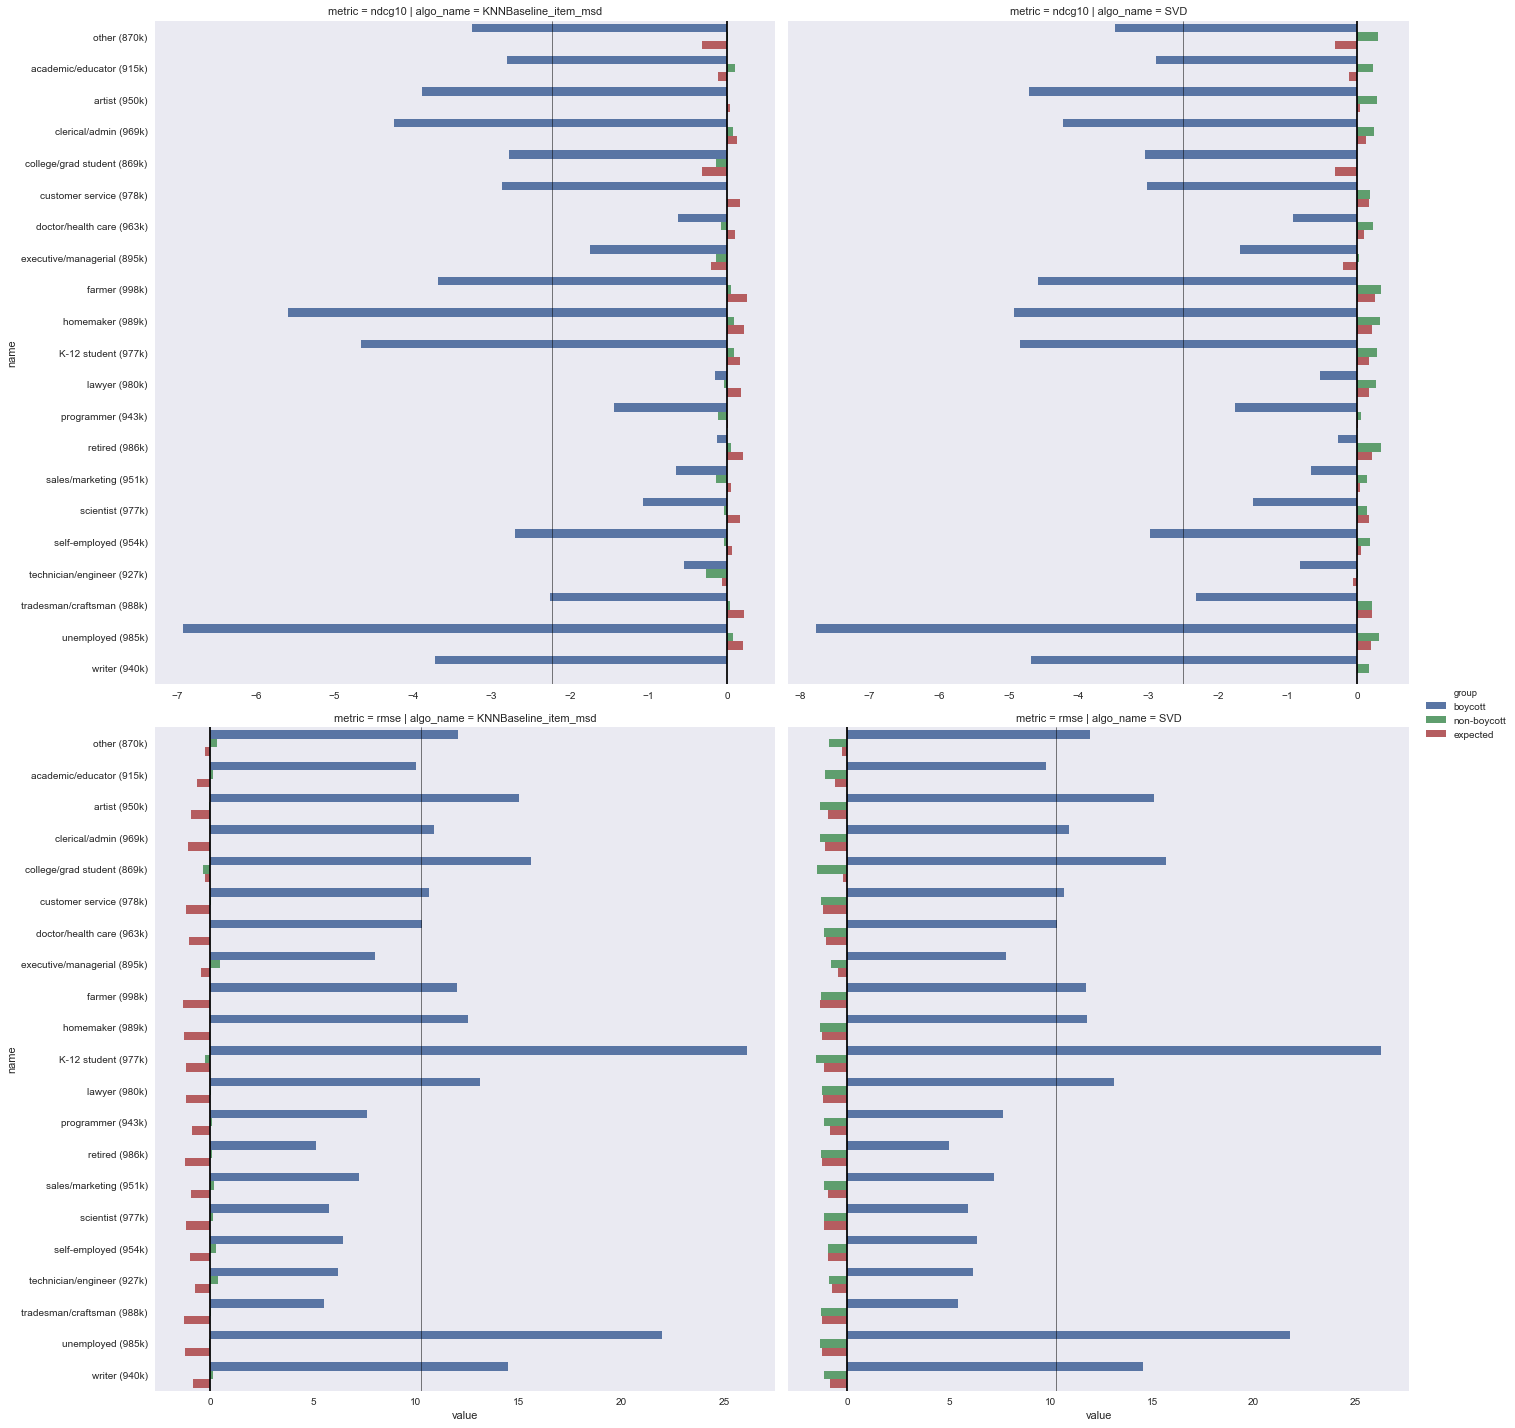

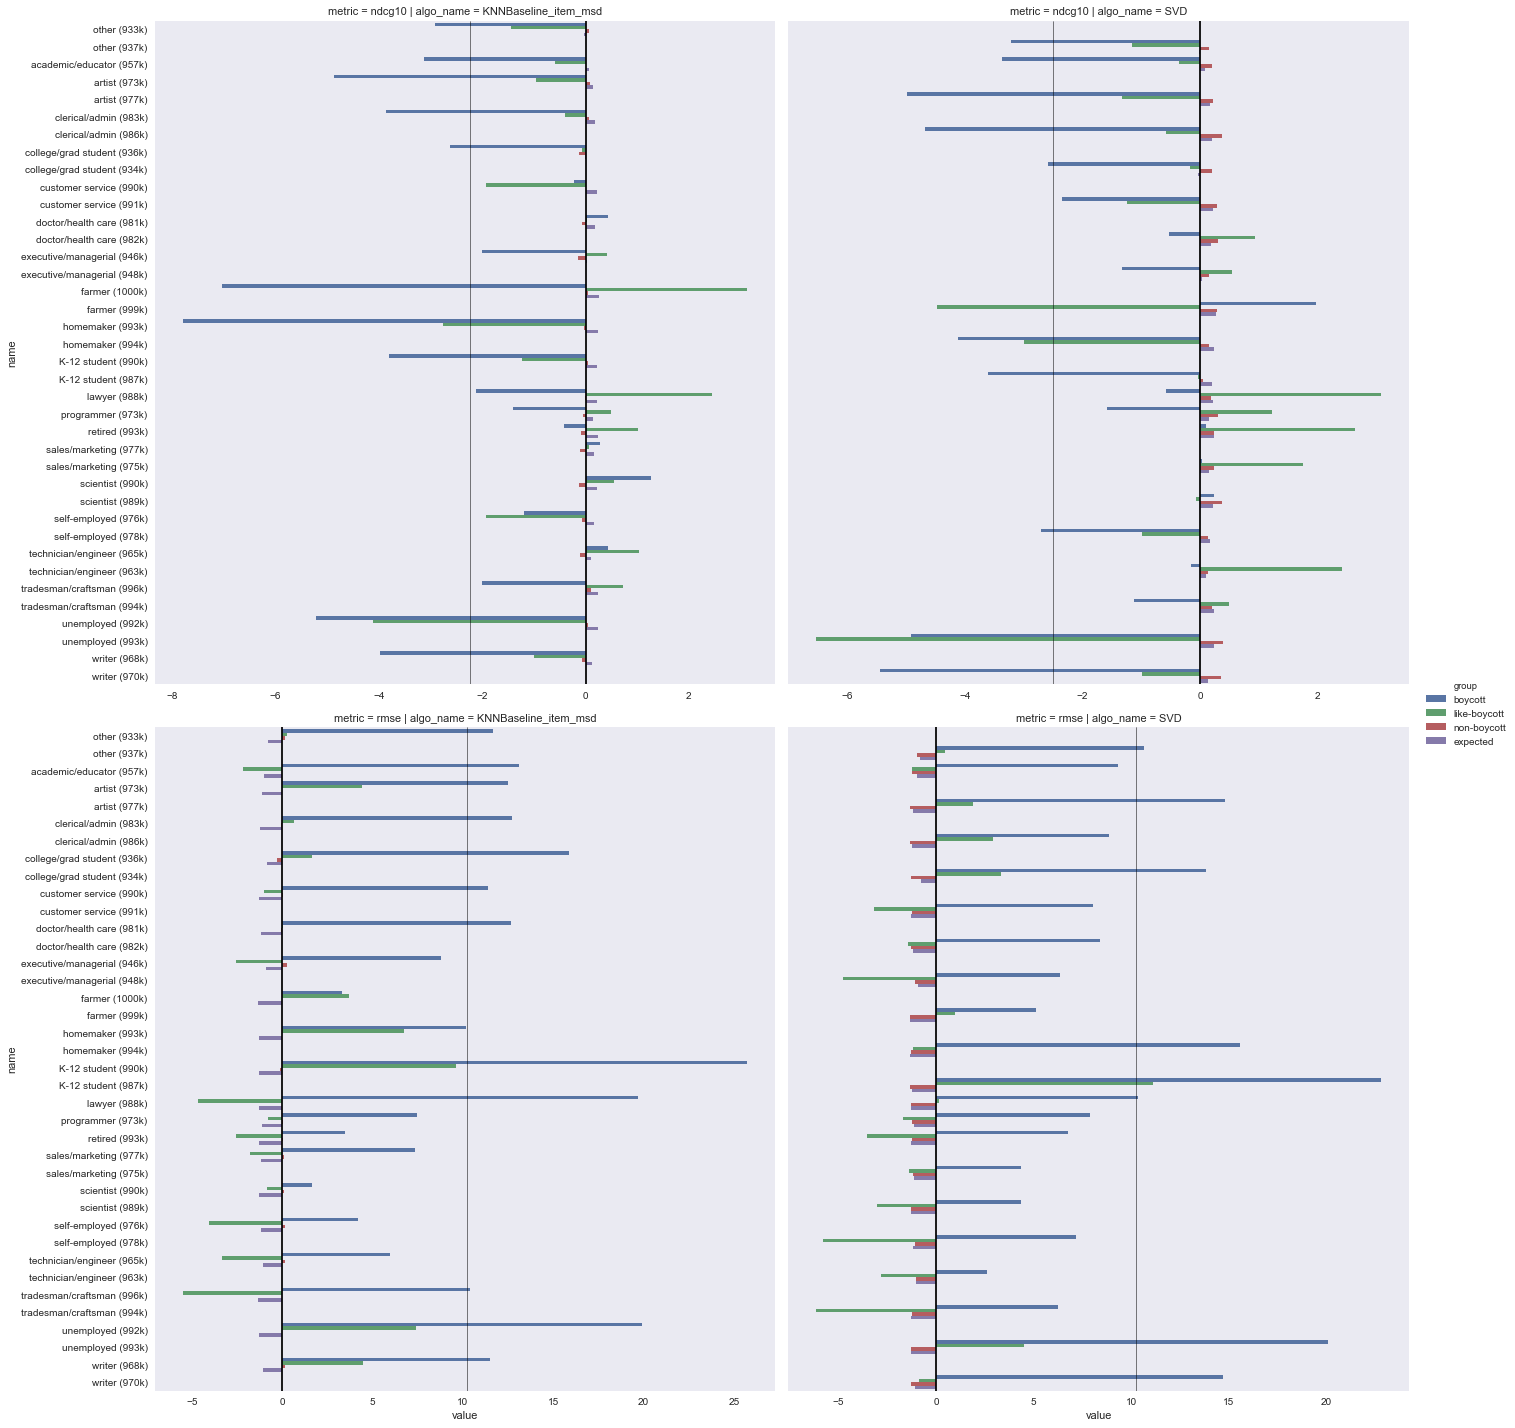

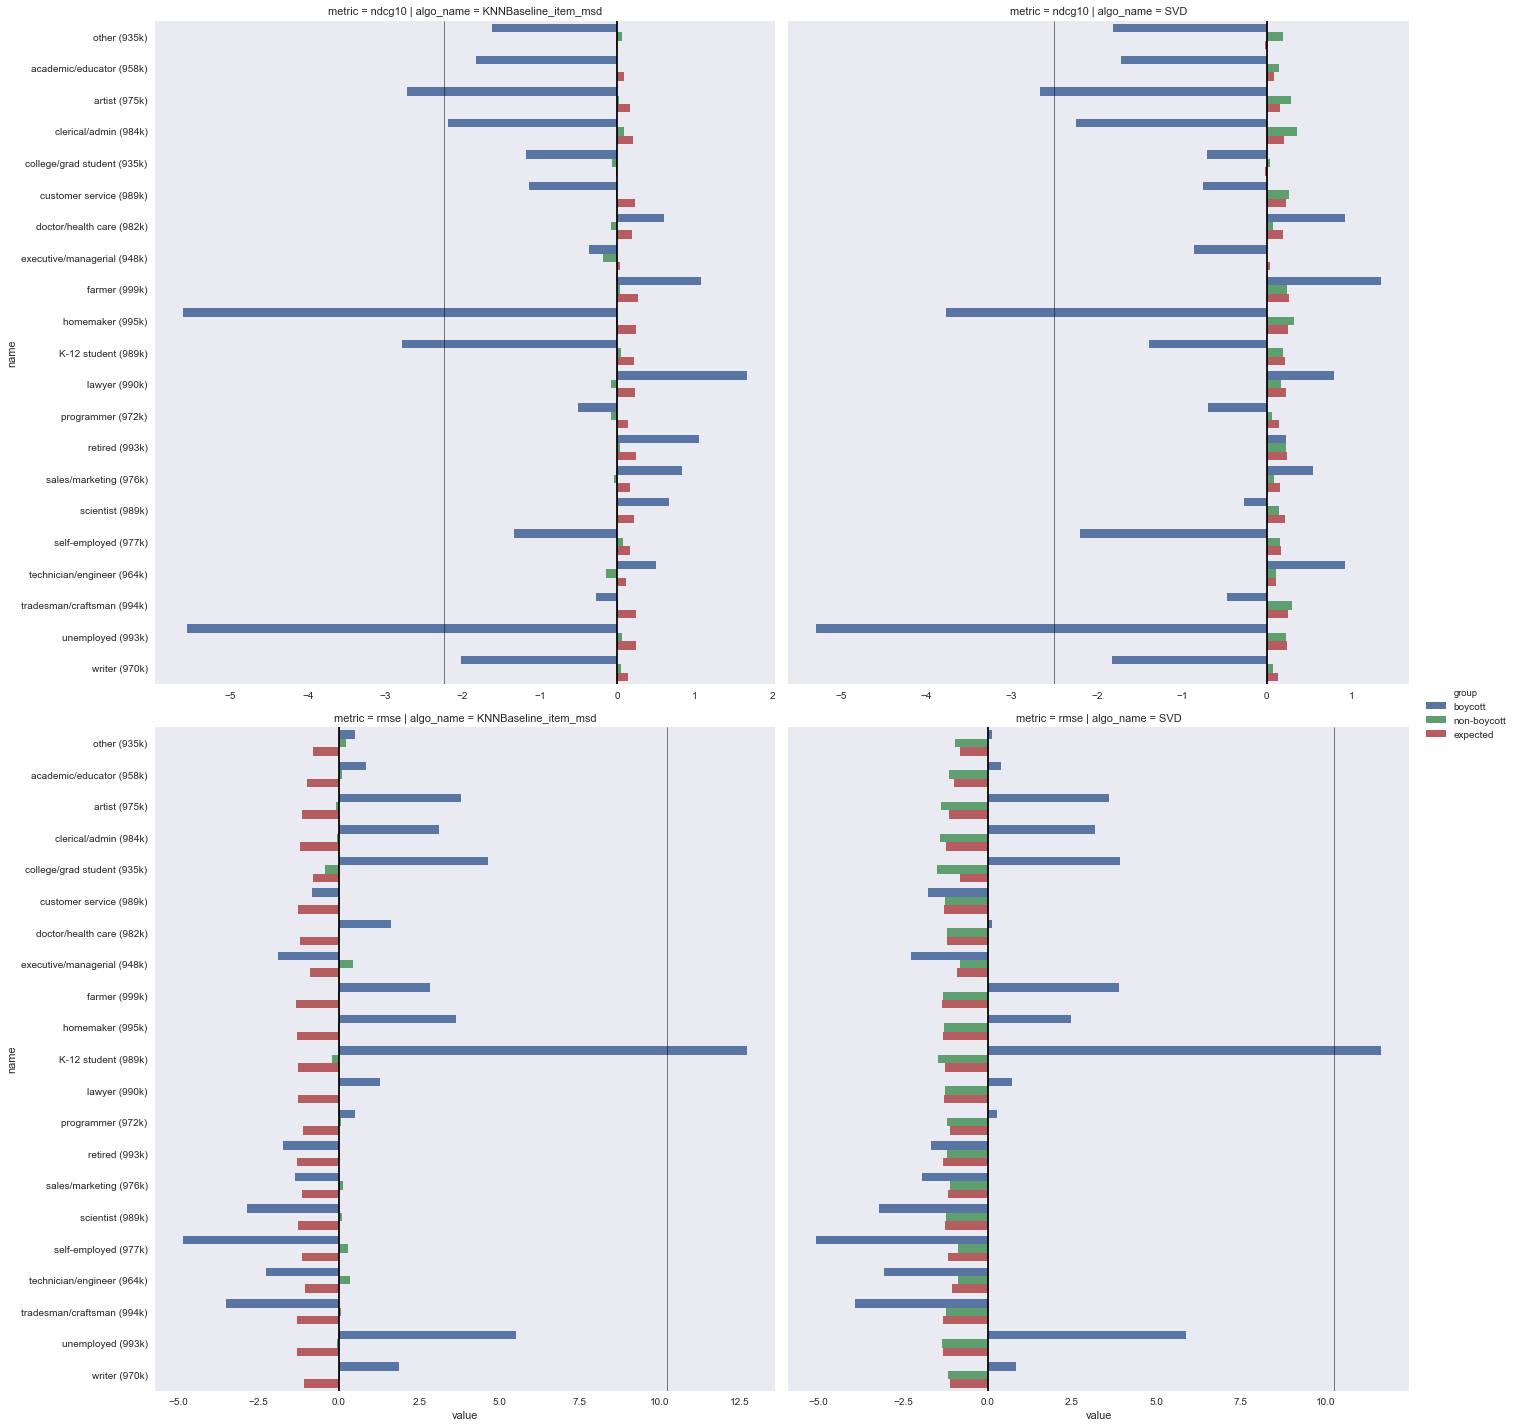

In [810]:
plot_all_three_scenarios(occupation_boycotts, size=10)